In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import time

import dpf
import dpf_toy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
iterations = 100

# (x, y, theta)
states = [np.array([0.0, 0.0, 0.0])]
controls = []
observations = []

beacon_observer = dpf_toy.BeaconObserver()
beacon_observer.add_beacon((5, 3), 0.2)
beacon_observer.add_beacon((22, 8), 0.5)

dynamics = dpf_toy.RobotDynamicsModel()

# Simulation
for _ in range(iterations):
    control = torch.from_numpy(np.random.uniform(
        low=[0, -0.1], high=[1, 0.1], size=(2,)).astype(np.float32))
    new_state = dynamics.forward(
        torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=True)

    states.append(new_state[0].numpy())
    controls.append(control.numpy())
true_states = np.array(states)

# Dead-reckoning
states = [true_states[0]]
for control in controls:
    new_state = dynamics.forward(
        torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=False)
    states.append(new_state[0].numpy())
dead_reckoned_states = np.array(states)


In [31]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Particle filter network
dynamics = dpf_toy.RobotDynamicsModel()
measurements = dpf_toy.DeepBeaconMeasurementModel()

torch.autograd.set_detect_anomaly(True)

pfnet = dpf.ParticleFilterNetwork(dynamics, measurements, 1.0).to(device)
print(pfnet)

ParticleFilterNetwork(
  (dynamics_model): RobotDynamicsModel()
  (measurement_model): DeepBeaconMeasurementModel(
    (observation_layers): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (state_layers): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (shared_layers): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=1, bias=True)
      (7): LogSigmoid()
    )
  )
)


In [32]:

model = pfnet

total_epochs = 0
optimizer = optim.Adam(model.parameters())

def set_lr(lr):
    print("Setting learning rate to", lr)
    for g in optimizer.param_groups:
        g['lr'] = lr

def train(epoch, log_interval=10):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        start = time.time()

        observations = beacon_observer.forward(true_states[1:])
        states = [true_states[0]]
        num_particles = 1000
        prev_particle_states = torch.FloatTensor(
            [true_states[0] for _ in range(num_particles)]).to(device)
        prev_particle_weights = torch.ones(num_particles).to(device)
        
        for i, (control, observation) in enumerate(zip(controls, observations)):
            # Type conversions
            observation = torch.from_numpy(observation.astype(np.float32)).to(device)
            control = torch.from_numpy(control.astype(np.float32)).to(device)

            # Particle filter network: forward
            best_state, particle_states, particle_weights = pfnet.forward(
                prev_particle_states, prev_particle_weights, observation, control)

            # Compute loss
            label_state = torch.from_numpy(true_states[i+1].astype(np.float32)).to(device)
            loss = F.mse_loss(best_state, label_state)

            prev_particle_states = particle_states
            prev_particle_weights = particle_weights

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            
            if i % 10 == 0:
                print("Training loss:", loss.cpu().detach().numpy())

        print()



        end = time.time()

        global total_epochs
        total_epochs += 1
        print('{}: {:.2f}s'.format(total_epochs, end-start))

In [41]:
set_lr(1e-4)
train(10)

Setting learning rate to 0.0001
Training loss: 7.360546
Training loss: 0.26652512
Training loss: 1.7054839
Training loss: 0.76070625
Training loss: 0.94111294
Training loss: 1.3777717
Training loss: 0.9791441
Training loss: 0.6167847
Training loss: 0.024880014
Training loss: 0.5119046

21: 1.20s
Training loss: 7.428559
Training loss: 0.23933725
Training loss: 1.8851708
Training loss: 0.6082273
Training loss: 0.99320704
Training loss: 2.495385
Training loss: 1.7807562
Training loss: 2.1396818
Training loss: 0.43657634
Training loss: 1.0185353

22: 1.23s
Training loss: 7.195537
Training loss: 0.40498558
Training loss: 1.4143163
Training loss: 0.71010315
Training loss: 0.7944672
Training loss: 2.0044262
Training loss: 1.6035453
Training loss: 1.3379674
Training loss: 1.118683
Training loss: 0.37089288

23: 1.30s
Training loss: 7.504543
Training loss: 0.20703448
Training loss: 1.4081666
Training loss: 0.7860719
Training loss: 2.0608897
Training loss: 4.296239
Training loss: 3.0363367
Train

In [46]:
observations = beacon_observer.forward(true_states[1:])
states = [true_states[0]]
num_particles = 100
particle_states = torch.FloatTensor(
    [true_states[0] for _ in range(num_particles)])
particle_weights = torch.ones(num_particles)

end = 100
for control, observation in zip(controls[:end], observations[:end]):
    # Type conversions
    observation = torch.from_numpy(observation.astype(np.float32))
    control = torch.from_numpy(control.astype(np.float32))

    # Particle filter network: forward
    best_state, particle_states, particle_weights = pfnet.forward(
        particle_states, particle_weights, observation, control, resample=False)

    states.append(best_state.detach().numpy())
pf_states = np.array(states)


In [47]:
def plot():
    # Plot trajectories
    plt.scatter(dead_reckoned_states[:, 0],
                dead_reckoned_states[:, 1], marker=".", label="Dead-reckoned")
    plt.scatter(true_states[:, 0], true_states[:, 1],
                marker=".", label="Ground-truth")
    plt.scatter(pf_states[:, 0], pf_states[:, 1],
                marker=".", label="Particle Filter")
    # print(pf_states)

    plt.scatter(particle_states.numpy()[:, 0], particle_states.numpy()[:, 1], marker=".", label="Particles")

    # Plot beacons
    beacon_locations = np.asarray(beacon_observer.locations)
    plt.scatter(beacon_locations[:, 0], beacon_locations[:, 1], label="Beacons")

    plt.legend()
    plt.show()

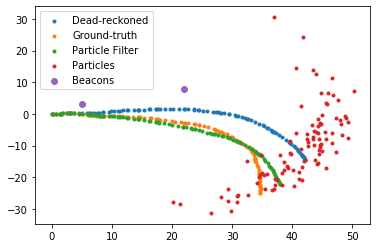

In [48]:
plot()

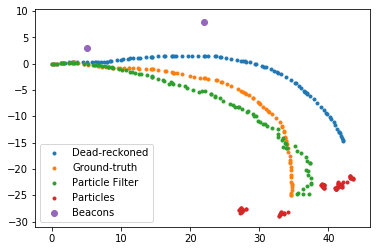

In [45]:
plot()